# Imports

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
%matplotlib notebook

import fastai
from fastai.vision import *
from fastai.vision.learner import model_meta

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import shutil


PATH = Path('/home/Deep_Learner/work/network/datasets/Hypophysenadenome/')
FONT_PATH=PATH/'1984-Happines-Regular.ttf'
ROIS_CORTICOTROP = PATH/'rois_corticotrop'
ROIS_CORTICOTROP_FILTERED = PATH/'rois_corticotrop_filtered'
ROIS_GONADOTROP = PATH/'rois_gonadotrop'
ROIS_GONADOTROP_FILTERED = PATH/'rois_gonadotrop_filtered'
TILES_CORTICOTROP = PATH/'tiles_corticotrop'
TILES_GONADOTROP = PATH/'tiles_gonadotrop'
TRAIN_NAME = 'tiles_train'
TRAIN = PATH/TRAIN_NAME
TEST_NAME = 'tiles_test'
TEST = PATH/TEST_NAME
LABELS_CORTICOTROP_NAME = 'KortikotropHA_gelabled.xlsx'
LABELS_CORTICOTROP = PATH/LABELS_CORTICOTROP_NAME
LABELS_GONADOTROP_NAME = 'GonadotropeHA_gelabled.xlsx'
LABELS_GONADOTROP = PATH/LABELS_GONADOTROP_NAME
MODEL_PATH_NAME = 'models'
MODEL_PATH = PATH/MODEL_PATH_NAME

ROIS_EXPERIMENTING = PATH/'rois_experimenting'
ROIS_EXPERIMENTING_FILTERED = PATH/'rois_experimenting_filtered'
TILES_EXPERIMENTING = PATH/'tiles_experimenting'

nw = 8   #number of workers for data loader
torch.backends.cudnn.benchmark=True

#def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
#        "Grab a batch of data and call reduction function `func` per channel"
#        funcs = ifnone(funcs, [torch.mean,torch.std])
#        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
#        return [func(channel_view(x), 1) for func in funcs]
#        
#vision.data.ImageDataBunch.batch_stats = batch_stats

sz = 512
bs = 8
epochs_frozen = 2
epochs_unfrozen = 20

#fastai defaults
tta_beta = 0.4 
tta_scale = 1.35
dropout = 0.5
wd = 0.01

#non defaults
#wd = 0.1 not better for se_resnext50
#dropout = 0.9


seed = 42
np.random.seed(seed)

num2lbs = {
    0:"corticotrop", 
    3:"silent",  
    8:"LH", 
    9:"FSH"
}

lbs2num = {l:n for n,l in num2lbs.items()}

def show(np):
    return util.np_to_pil(np)

Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

def show_multiple_images(path, rows = 3, figsize=(128, 64)):
    imgs = [open_image(p) for p in path.ls()]
    show_all(imgs=imgs, r=rows, figsize=figsize)
    
def show_multiple_images_big(path:pathlib.Path):
    for p in path.ls():
        plt.imshow(mpimg.imread(str(p)))
        plt.show()
        
def get_id_from_path(path):
    split = path.stem.split('-')
    return f'{split[0]}-{split[1]}'

ImportError: /opt/conda/lib/python3.6/site-packages/torchvision/_C.cpython-36m-x86_64-linux-gnu.so: undefined symbol: _ZN2at7getTypeERKNS_6TensorE

# Extra Models

In [2]:
#https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

## utils

In [3]:
from fastai.torch_core import flatten_model

def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


## Models

### NASNetAMobile

In [4]:
def identity(x): return x

def nasnetamobile(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.nasnetamobile(pretrained=pretrained, num_classes=1000)  
    model.logits = identity
    model_meta[nasnetamobile] =  { 'cut': identity, 'split': lambda m: (list(m[0][0].children())[8], m[1]) }
    return nn.Sequential(model)

#arch_summary(lambda _: nasnetamobile(False)[0])

### se_resnext50

In [5]:
def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    _se_resnet_meta = {'cut': -2, 'split': lambda m: (m[0][3], m[1]) }
    model_meta[se_resnext50_32x4d] =  _se_resnet_meta
    return model

#arch_summary(lambda _: pretrainedmodels.se_resnext50_32x4d(pretrained=None))

# n 

In [6]:
#n='test'

n = np.load('n.npy')
print(n)

m = n+1
m=2
np.save('n', m)
print(m)

2
2


# Data 

## split dataset into train, valid and test set

In [7]:
##
#specify test data and move it to a seperate folder (required only once)
##
#tile_paths_all = [p for p in (TRAIN.ls()) if p.suffix == '.png']
#ids = []
#for p in tqdm(tile_paths_all):
#    ids.append(get_id_from_path(p))
#ids = list(set(ids))
#train_and_valid_pct = 0.9
#test_pct = 0.1
#ids_train_and_valid, ids_test = train_test_split(ids, test_size=test_pct, random_state=seed)

##
#move test images to extra folder
##
#for id in tqdm(ids_test):
#    for p in tile_paths_all:
#        if id in str(p):
#            !mv {p} {TEST}

##
#split remaining images into train and val sets
##
tile_paths_train_and_valid = [p for p in (TRAIN.ls()) if p.suffix == '.png']
ids_train_and_val = []
for p in tqdm(tile_paths_train_and_valid):
    ids_train_and_val.append(get_id_from_path(p))       
ids_train_and_val = list(set(ids_train_and_val))
train_pct = 0.8
valid_pct = 0.2
ids_train, ids_val = train_test_split(ids_train_and_val, test_size=valid_pct, random_state=seed)

## Transforms

In [8]:
tfms = get_transforms(flip_vert=True)

<IPython.core.display.Javascript object>


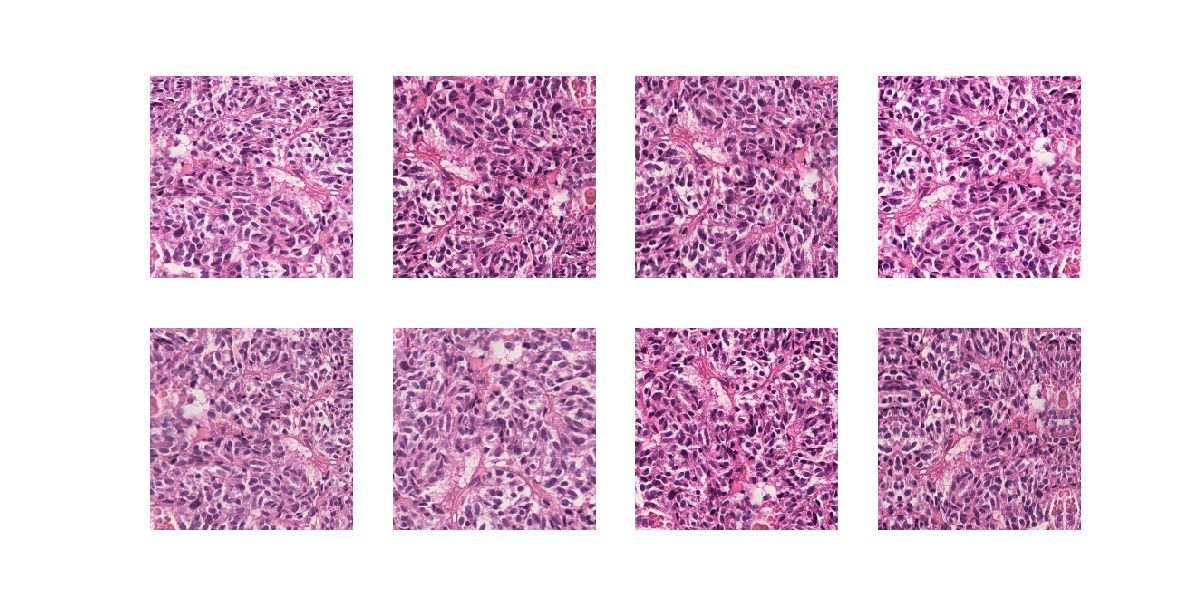

In [9]:
#tfms = ([RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
#        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
#        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
#        [])

def get_ex(): return open_image(str(TRAIN.ls()[0]))

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

plots_f(2, 4, 12, 6, size=224)

## Datablock API

In [10]:
df_c = pd.read_excel(LABELS_CORTICOTROP)
def label_func(path):
    s = path.stem
    if('LH+FSH' in s):
        return [lbs2num['LH'],lbs2num['FSH']]
    elif 'LH' in s:       
        return [lbs2num['LH']]
    elif 'FSH' in s:        
        return [lbs2num['FSH']]
    else:
        result = [lbs2num['corticotrop']]
        id = get_id_from_path(path)
        l = df_c.loc[df_c.id == id].label
        try:
            if str(lbs2num['silent']) in str(l.values[0]):
                result.append(3)
        except:
            print(l.values)
            print(s)
            print(get_id_from_path(path))
            raise
        return result
    
def split_func(path):
    return get_id_from_path(path) in ids_val

In [11]:
data = ImageList.from_folder(path=TRAIN, extensions=['.png'])
data = data.split_by_valid_func(split_func)
data = data.label_from_func(label_func)
data = data.transform(tfms=tfms, size=sz)
data = data.add_test_folder(test_folder=TEST)
data = data.databunch(bs=bs, num_workers=nw, path=PATH)
data = data.normalize()

# Metrics 

# Learner

## Create

In [13]:
arch = se_resnext50_32x4d
learner = cnn_learner(data=data, 
                     base_arch=arch, 
                     metrics=[accuracy_thresh], 
                     ps=dropout, 
                     pretrained=True, 
                     wd = wd)

## Name

In [14]:
nameBase = f'{n}-{arch.__name__}-size{sz}-bs{bs}'
nameBase

'2-se_resnext50_32x4d-size512-bs8'

## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<IPython.core.display.Javascript object>


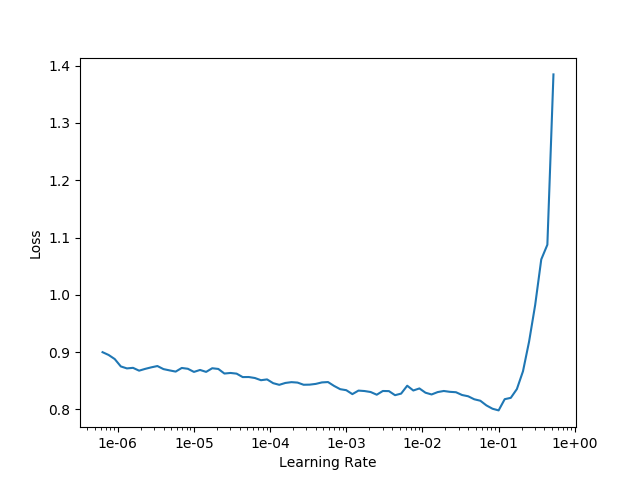

In [15]:
learner.lr_find()
learner.recorder.plot()

In [16]:
lr = 1e-2

In [ ]:
learner.fit_one_cycle(cyc_len=epochs_frozen, max_lr=lr)

In [ ]:
nameHead = f'{nameBase}-head'

In [ ]:
learner.save(nameHead)

In [12]:
#learner.load(nameHead)

Learner(data=ImageDataBunch;

Train: LabelList (113208 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
8;9,8;9,0;3,8;9,9
Path: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_train;

Valid: LabelList (44440 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
9,0,0,0,0
Path: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_train;

Test: LabelList (13805 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /home/Deep_Learner/work/network/datasets/Hypophysenadenome/tiles_train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()

In [ ]:
learner.recorder.plot(skip_start=0)

In [15]:
lr2 = 
lr3 = 

In [ ]:
learner.fit_one_cycle(cyc_len=epochs_unfrozen, max_lr=slice(lr2, lr3))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.322954,1.223999,0.879579,2:16:15
1,0.331237,0.499913,0.888754,2:25:17
2,0.315572,0.447129,0.897885,2:23:43
3,0.292408,0.358864,0.897204,2:26:40
4,0.285531,0.459901,0.879214,2:33:43
5,0.297472,0.409210,0.890943,2:29:24
6,0.276409,0.388353,0.889553,2:29:29
7,0.246918,0.332012,0.891635,2:24:01


<IPython.core.display.Javascript object>


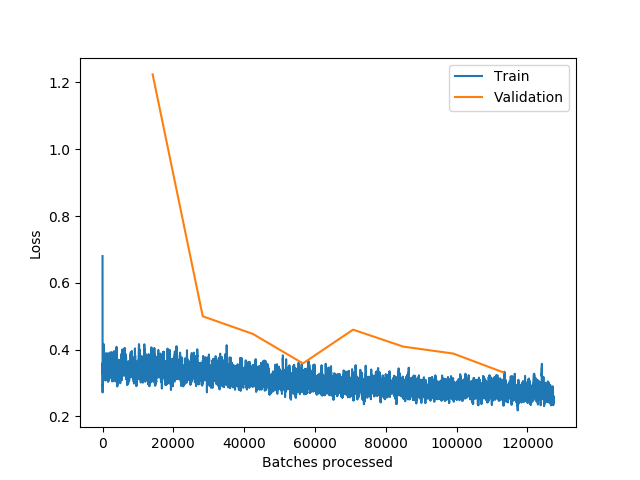

In [17]:
learner.recorder.plot_losses()

In [18]:
nameComplete = f'{nameBase}-complete'
learner.save(nameComplete)

### best learning schedules

# Predicting on test set

In [258]:
def one_hot_encode(predicted_classes:list, all_classes:list):
    for c in predicted_classes:
        assert c in all_classes
    n = len(all_classes)
    res = np.zeros(n, int)
    for i, c in enumerate(all_classes):
        if c in predicted_classes:
            res[i] = 1 
    return res

In [ ]:
#key:path, value:MultiCategory
test_path_to_pred = {}
for n, path in tqdm(enumerate(learner.data.test_ds.items), total=len(learner.data.test_ds.items)):
    pred = learner.predict(learner.data.test_ds[n][0])
    test_path_to_pred[path] = pred

In [259]:
#key: id of a case; value: list with this syntax  
#[<number of tiles>, 
#[<number of occurenses of class1 over all tiles per id>, 
#<number of occurenses of class2 over all tiles per id>, ..., 
#<number of occurenses of classN over all tiles per id>],
#y_true]
class_occurence_per_id = {}

for path, pred in test_path_to_pred.items():   
    id = get_id_from_path(path)
    if id in class_occurence_per_id:
        v = class_occurence_per_id[id]
        v[0] = v[0] + 1
        v[1] = v[1] + pred[1]
        class_occurence_per_id[id] = v
    else:
        class_occurence_per_id[id] = [1, pred[1], one_hot_encode(label_func(path), lbs2num.values())]

In [260]:
class_occurence_per_id

{'2143-15': [941, tensor([865., 417., 101.,   9.]), array([1, 1, 0, 0])],
 '208-16': [1184, tensor([ 121.,  421., 1049., 1012.]), array([0, 0, 1, 0])],
 '967-16': [609, tensor([608.,  27.,   1.,   2.]), array([1, 0, 0, 0])],
 '1227-12': [295, tensor([171.,   2.,  75.,  36.]), array([0, 0, 1, 1])],
 '29-19': [967, tensor([935., 173.,  27.,  38.]), array([1, 1, 0, 0])],
 '2206-15': [751, tensor([555.,  76.,  32.,  13.]), array([0, 0, 0, 1])],
 '433-14': [2118, tensor([ 286.,  159., 1634.,  837.]), array([0, 0, 1, 0])],
 '1078-14': [560, tensor([190., 247., 121., 359.]), array([0, 0, 0, 1])],
 '357-13': [242, tensor([  8.,   1., 218., 157.]), array([0, 0, 1, 1])],
 '1820-12': [554, tensor([129.,   1.,  57., 350.]), array([0, 0, 1, 1])],
 '1004-18': [452, tensor([364.,   0.,  17.,   4.]), array([1, 0, 0, 0])],
 '1567-12': [81, tensor([74.,  0.,  1.,  2.]), array([1, 0, 0, 0])],
 '1845-15': [307, tensor([ 15.,   1., 296.,  91.]), array([0, 0, 0, 1])],
 '886-15': [564, tensor([  4.,   2., 55

# Interpreter

In [19]:
interp = ClassificationInterpretation.from_learner(learner)

In [47]:
def custom_confusion_matrix(self, slice_size:int=1):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        else:
            cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)
            for i in range(0, self.y_true.shape[0], slice_size):
                #cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            #& (self.y_true[i:i+slice_size]==x[:,None,None])).sum(2)
                cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            & (self.y_true[i:i+slice_size]==(x[:,None,None]).float())).sum(2)
                torch.add(cm, cm_slice, out=cm)
        return to_np(cm)
    
fastai.train.ClassificationInterpretation.confusion_matrix = custom_confusion_matrix

<IPython.core.display.Javascript object>


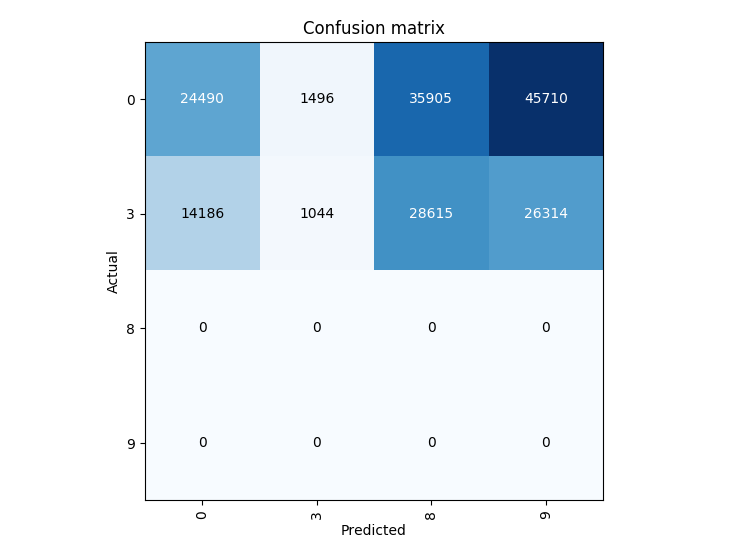

In [51]:
interp.plot_confusion_matrix()

In [53]:
interp.plot_top_losses(10)

<IPython.core.display.Javascript object>

IndexError: index 68933 is out of bounds for axis 0 with size 44440

# Validation Set

## Prediction

In [ ]:
preds,y=learner.TTA(ds_type=DatasetType.Valid, scale=1)

## AUC Score

In [ ]:
pred_score_tta_1=auc_score_1(preds,y)
pred_score_tta_1

In [ ]:
pred_score_tta_2=auc_score_2(preds,y)
pred_score_tta_2

## ROC curve and AUC on validation set

In [ ]:
fpr, tpr, thresholds, roc_auc = roc_curve_custom(preds, y)

In [ ]:
roc_auc

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## Finding threshold on validation set

In [ ]:
import scipy.optimize as opt
from sklearn.model_selection import train_test_split

In [ ]:
pred = preds[:, 1]

In [ ]:
pred_tensor = pred
y_tensor = y

pred = np.asarray(pred)
y = np.asarray(y)

In [ ]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.,d=25.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(1)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
import sklearn
th = fit_val(pred, y)
print('Thresholds: ',th)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.0): ', sklearn.metrics.f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))

In [ ]:
from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score +=  sklearn.metrics.f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ', sklearn.metrics.f1_score(y, pred>th, average='macro'))
print('F1 micro: ', sklearn.metrics.f1_score(y, pred>th, average='micro'))


print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

In [ ]:
f1 =  sklearn.metrics.f1_score(y, pred>th, average=None)
bins = np.linspace(pred[:].min(), pred[:].max(), 50)
plt.hist(pred[y[:] == 0][:], bins, alpha=0.5, log=True, label='false')
plt.hist(pred[y[:] == 1][:], bins, alpha=0.5, log=True, label='true')
plt.legend(loc='upper right')
plt.axvline(x=th[0], color='k', linestyle='--')
plt.show()

# Test Set

## Single Model

In [ ]:
#learner.load('')

In [ ]:
nameBase

In [ ]:
preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test, scale=tta_scale, beta=tta_beta)
preds_test = preds_test_tta

#preds_test, _ = learner.get_preds(ds_type=DatasetType.Test)

In [ ]:
name = f'{nameBase}'

## Ensembling

In [ ]:
arch_list = []

In [ ]:
dict_arch_savedModel = {}

In [ ]:
str([a.__name__ for a in arch_list])

In [ ]:
name = f'{n}-{str([a.__name__ for a in arch_list])}_sz{sz}_ensembled'; name

In [ ]:
predsList = []
for arch in arch_list:
    learner = cnn_learner(data=data, base_arch=arch)
    learner.load(dict_arch_savedModel[arch])
    preds_test_tta,y_test_tta=learner.TTA(ds_type=DatasetType.Test, scale=1)
    predsList.append(preds_test_tta)

In [ ]:
preds_ensembled = predsList[0]
for n, _ in enumerate(predsList):
    if n == 0:
        continue
    else:
        preds_ensembled = preds_ensembled + predsList[n]
preds_ensembled = preds_ensembled/len(predsList)

In [ ]:
preds_test = preds_ensembled